# Importing Libraries
Word-Importance paper(A Corpus for Modeling Word Importance in Spoken Dialogue Transcripts): https://arxiv.org/pdf/1801.09746.pdf

In [45]:
!sudo pip3 install pandas


We trust you have received the usual lecture from the local System
Administrator. It usually boils down to these three things:

    #1) Respect the privacy of others.
    #2) Think before you type.
    #3) With great power comes great responsibility.

[sudo] password for aa7510: 


In [44]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import string
import numpy as np
import random
import heapq
import gensim
from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import pandas as pd

# Load pre-trained model's tokenizer (BERT vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


ModuleNotFoundError: No module named 'pandas'

In [2]:
# Variable Definition
folder = {
    '20':['2005'],
    '21':['2191'],
    '22':['2222'],
    '23':['2348'],
    '24':['2450'],
    '25':['2565'],
    '26':['2636'],
    '27':['2710'],
    '28':['2886'],
    '30':['3044','3083'],
    '32':['3203'],
    '33':['3301','3324'],
    '36':['3601'],
    '38':['3817'],
    '40':['4010','4021'],
    '43':['4320'],
    '44':['4400'],
    '45':['4531'],
    '47':['4721']
}

file_type = ['A','B']
size_of_bow = 100
threshold = 0.4

POS_IMPORTANCE = {'NN':3.95,'NNP':3.95,'NNS':3.95,
                  'VB':3.82, 'VBZ':3.82,'VBP':3.82,
                  'VBG':3.82,'VBD':3.82,'VBN':3.82,
                  'JJ':3.80,'RB':3.43 }


# Bag of Words Model
Measuring word importance using bag of words model.

# Text Preprocessing

In [3]:
# Text Preprocessor
 # Prcessing the text: to extract the text and corresponding sense from each line of the file
def process_text(line):
    splitLine = line.split(" ")
    return splitLine[-1].replace("\n","")

def process_wimp(line):
    splitLine = line.split(" ")
    last_word = splitLine[-1].replace("\n","")
    splitLine[-1] =  last_word
    return splitLine

In [4]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], '')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text
def lemmatizing(data):
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text
def normalize_text(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = convert_numbers(data)
    data = lemmatizing(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = remove_punctuation(data) 
    return data

In [5]:
# Read words from the switchboard word list
def get_words_list(file_name):
    files = open(file_name)
    text = ""
    for sentence in files.readlines():
        sentence = sentence.split(" ")
        actual_sentence = " ".join(sentence[3:])
        text = text + actual_sentence
    
    return text

In [6]:
def get_word_freq(file):
    corpus = get_words_list(file)
    wordfreq = {}
    tokens = nltk.word_tokenize(str(corpus))
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1
    return wordfreq

In [7]:
def make_bag_of_words(file):
    wordfreq = get_word_freq(file)
    most_freq = heapq.nlargest(size_of_bow, wordfreq, key=wordfreq.get)
    return most_freq

In [8]:
def get_sentence_list(file_name):
    files = open(file_name)
    sentence_set=[]
    for sentence in files.readlines():
        sentence = sentence.split(" ")
        actual_sentence = " ".join(sentence[3:])
        sentence_set.append(actual_sentence.replace("\n",""))
    return sentence_set

In [9]:
def get_word_importance(file):
    corpus = get_sentence_list(file)
    sentence_vectors = []
    most_freq = make_bag_of_words(file)
    for sentence in corpus:
        sentence = normalize_text(sentence)
#         print(sentence)
        sentence_tokens = nltk.word_tokenize(str(sentence))
        sent_vec = []
        for token in sentence_tokens:
            if token in most_freq:
                sent_vec.append(1)
            else:
                sent_vec.append(0)

        sentence_vectors.append(sent_vec)
#     print(sentence_vectors)
    return sentence_vectors

# Performance Measure
Right now the length of this word importance and length of the kafles' word importanfeis not equal

In [10]:
def get_wimp_scores(file_name ):
    files = open(file_name)
    scores = []
    for sentence in files.readlines():
        score_array = process_wimp(sentence) 
        scores.append(score_array[3:])

    return scores

In [11]:
BOW_MSE = 0
BOW_Accuracy = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            bow = get_word_importance(file)
            scores = get_wimp_scores(wimp_file)

            total = 0 
            correct = 0
            for i in range(0,len(scores)):

                if len(bow[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    for j in range(0,len(scores[i])):

                        if (float(bow[i][j])>threshold and float(scores[i][j])>threshold) or (float(bow[i][j])<=threshold and float(scores[i][j])<=threshold):
                            correct = correct +1
                            BOW_MSE = BOW_MSE + pow(float(bow[i][j])-float(threshold),2)


            accuracy = correct/total
            BOW_Accuracy.append(accuracy)
            print("Accuracy:",accuracy)
print(BOW_MSE)
        

Accuracy: 0.17378640776699028
Accuracy: 0.21851851851851853
Accuracy: 0.22713864306784662
Accuracy: 0.18508092892329345
Accuracy: 0.14345991561181434
Accuracy: 0.1634182908545727
Accuracy: 0.2249488752556237
Accuracy: 0.251434034416826
Accuracy: 0.23314917127071824
Accuracy: 0.1902834008097166
Accuracy: 0.22535211267605634
Accuracy: 0.2568493150684932
Accuracy: 0.18274111675126903
Accuracy: 0.2767857142857143
Accuracy: 0.25901639344262295
Accuracy: 0.2837465564738292
Accuracy: 0.21161825726141079
Accuracy: 0.2403846153846154
Accuracy: 0.22288261515601784
Accuracy: 0.2135593220338983
Accuracy: 0.22968197879858657
Accuracy: 0.20673076923076922
Accuracy: 0.26019690576652604
Accuracy: 0.24472573839662448
Accuracy: 0.2261640798226164
Accuracy: 0.16730038022813687
Accuracy: 0.16265060240963855
Accuracy: 0.18686868686868688
Accuracy: 0.2342814371257485
Accuracy: 0.2350061199510404
Accuracy: 0.28113879003558717
Accuracy: 0.24662162162162163
Accuracy: 0.2127659574468085
Accuracy: 0.224609375
Ac

# TF-IDF Implementation
The idea behind the TF-IDF approach is that the words that are more common in one sentence and less common in other sentences should be given high weights.

In [12]:
def measure_idf(file):
    word_idf_values = {}
    most_freq = make_bag_of_words(file)
    corpus = get_sentence_list(file)
    for token in most_freq:
        doc_containing_word = 0
        for document in corpus:
            if token in nltk.word_tokenize(document):
                doc_containing_word += 1
        word_idf_values[token] = np.log(len(corpus)/(1 + doc_containing_word))
#     print(word_idf_values)
    return word_idf_values

In [13]:
def measure_tf_score(file):
    word_tf_values = {}
    corpus = get_sentence_list(file)
    most_freq = make_bag_of_words(file)
    for token in most_freq:
        sent_tf_vector = []
        for document in corpus:
            doc_freq = 0
            for word in nltk.word_tokenize(document):
                if token == word:
                      doc_freq += 1

            word_tf = doc_freq/len(nltk.word_tokenize(document))
            sent_tf_vector.append(word_tf)
        word_tf_values[token] = sent_tf_vector
    return word_tf_values

In [14]:
def measure_tf_idf_score(file):
    word_tf_values = measure_tf_score(file)
    word_idf_values =  measure_idf(file)
    tfidf_values = []
    for token in word_tf_values.keys():
        tfidf_sentences = []
        for tf_sentence in word_tf_values[token]:
            tf_idf_score = tf_sentence * word_idf_values[token]
            tfidf_sentences.append(tf_idf_score)
        tfidf_values.append(tfidf_sentences)
    return tfidf_values

In [15]:
def get_tf_idf_word_importance(file):
    corpus = get_sentence_list(file)
    sentence_vectors = []
    word_tf_values = measure_tf_score(file)
    word_idf_values = measure_idf(file)
    count = 0 
    for sentence in corpus:
        sentence = normalize_text(sentence)
        sentence_tokens = nltk.word_tokenize(str(sentence))
        sent_vec = []
        for token in sentence_tokens:
            if token in word_tf_values:
                sent_vec.append(word_tf_values[token][count]*word_idf_values[token])
            else:
                sent_vec.append(0)
        
        sentence_vectors.append(sent_vec)
        count=count+1
    return sentence_vectors

# Performance Measure
Right now the length of this word importance and length of the kafles' word importanfeis not equal

In [16]:
def compare(X, Y):
    if (0 <= X <= 0.2 and 0 <= Y <= 0.2) or (0.2 < X <= 0.4 and 0.2 < Y <= 0.4) or (0.4 < X <= 0.6 and 0.4 < Y <= 0.6) or (0.6 < X <= 0.8 and 0.6 < Y <= 0.8)or (0.8 < X <= 1 and 0.8 < Y <= 1):
        return True
    else: 
        return False

In [17]:
def get_wimp_scores(file_name = wimp_file):
    files = open(file_name)
    scores = []
    for sentence in files.readlines():
        score_array = process_wimp(sentence) 
        scores.append(score_array[3:])

    return scores

In [18]:
TF_IDF_MSE = 0
TF_IDF_Accuracy = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            sent_vector = get_tf_idf_word_importance(file)
            scores = get_wimp_scores(wimp_file)
            total = 0 
            correct = 0
            for i in range(0,len(scores)):

                if len(sent_vector[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    for j in range(0,len(scores[i])):
                        if compare(float(sent_vector[i][j]), float(scores[i][j])):
                            correct = correct +1
                            TF_IDF_MSE = TF_IDF_MSE + pow((float(sent_vector[i][j])-float(scores[i][j])),2)
            accuracy = correct/total
            TF_IDF_Accuracy.append(accuracy)
            print("Accuracy: "+ str(accuracy))
print("SE:" +str(TF_IDF_MSE))

Accuracy: 0.5631067961165048
Accuracy: 0.44814814814814813
Accuracy: 0.4026548672566372
Accuracy: 0.41731175228712175
Accuracy: 0.5147679324894515
Accuracy: 0.5097451274362819
Accuracy: 0.45194274028629855
Accuracy: 0.5210325047801148
Accuracy: 0.41104972375690607
Accuracy: 0.5236167341430499
Accuracy: 0.5736235595390525
Accuracy: 0.4041095890410959
Accuracy: 0.5042301184433164
Accuracy: 0.53125
Accuracy: 0.32131147540983607
Accuracy: 0.3443526170798898
Accuracy: 0.4190871369294606
Accuracy: 0.38653846153846155
Accuracy: 0.5230312035661219
Accuracy: 0.5067796610169492
Accuracy: 0.5070671378091873
Accuracy: 0.5096153846153846
Accuracy: 0.4092827004219409
Accuracy: 0.44936708860759494
Accuracy: 0.3348115299334812
Accuracy: 0.3288973384030418
Accuracy: 0.4457831325301205
Accuracy: 0.29545454545454547
Accuracy: 0.5516467065868264
Accuracy: 0.40269277845777235
Accuracy: 0.21352313167259787
Accuracy: 0.3310810810810811
Accuracy: 0.549645390070922
Accuracy: 0.41796875
Accuracy: 0.318059299191

# Topic Modelling

In [88]:
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [89]:
count = 1
for key in folder.keys():
    for value in folder[key]:
        if count ==1:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+"A-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+"A-ms98-a-trans.text"
            corpus = get_sentence_list(file)
            processed_docs = []
            for sent in corpus:
                for word in preprocess(sent):
                    if word not in ['yeah','silenc', 'laughter']:
                        processed_docs.append(word)
                
            
        count=count+1
processed_docs = [processed_docs]
dictionary = gensim.corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
print(bow_corpus)


I1203 19:17:23.400736 139821617399616 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I1203 19:17:23.401627 139821617399616 dictionary.py:214] built Dictionary(143 unique tokens: ['actual', 'allevi', 'alzheim', 'apart', 'avel']...) from 1 documents (total 310 corpus positions)


[[(0, 4), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 2), (7, 1), (8, 1), (9, 1), (10, 5), (11, 1), (12, 3), (13, 2), (14, 6), (15, 2), (16, 3), (17, 1), (18, 7), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 3), (25, 5), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 1), (36, 1), (37, 1), (38, 1), (39, 5), (40, 1), (41, 2), (42, 1), (43, 10), (44, 2), (45, 3), (46, 2), (47, 2), (48, 1), (49, 1), (50, 1), (51, 2), (52, 3), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 5), (67, 1), (68, 1), (69, 1), (70, 2), (71, 2), (72, 2), (73, 2), (74, 26), (75, 1), (76, 6), (77, 1), (78, 3), (79, 1), (80, 1), (81, 1), (82, 3), (83, 1), (84, 14), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 2), (91, 1), (92, 2), (93, 6), (94, 3), (95, 3), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 8), (106, 2), (107, 1), (108, 1), (109, 1), (110,

In [90]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 1, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

topics_words=lda_model.show_topics(num_topics=1, num_words=50,formatted=False)
# print(topics_words[0][1])

total_weights=0
#Below Code Prints Only Words 
for words, weights in topics_words[0][1]:
    print(words,": ",weights)
    total_weights = total_weights + weights
print(total_weights)

I1203 19:17:23.579481 139821617399616 ldamodel.py:557] using symmetric alpha at 1.0
I1203 19:17:23.580020 139821617399616 ldamodel.py:557] using symmetric eta at 1.0
I1203 19:17:23.580411 139821617399616 ldamodel.py:481] using serial LDA version on this node
I1203 19:17:23.581177 139821617399616 ldamulticore.py:238] running online LDA training, 1 topics, 10 passes over the supplied corpus of 1 documents, updating every 4000 documents, evaluating every ~1 documents, iterating 50x with a convergence threshold of 0.001000
I1203 19:17:23.582309 139821617399616 ldamulticore.py:279] training LDA model using 2 processes
I1203 19:17:23.596432 139821617399616 ldamulticore.py:294] PROGRESS: pass 0, dispatched chunk #0 = documents up to #1/1, outstanding queue size 1
I1203 19:17:23.601920 139821617399616 ldamodel.py:1171] topic #0 (1.000): 0.060*"know" + 0.035*"think" + 0.033*"mean" + 0.024*"famili" + 0.020*"probabl" + 0.018*"come" + 0.015*"nois" + 0.015*"children" + 0.015*"like" + 0.013*"thing"


know :  0.059603263
think :  0.035320405
mean :  0.033112872
famili :  0.024282744
probabl :  0.01986768
come :  0.017660148
children :  0.015452617
nois :  0.015452617
like :  0.015452617
decis :  0.013245086
care :  0.013245086
extend :  0.013245086
home :  0.013245086
thing :  0.013245086
visit :  0.011037557
actual :  0.011037556
live :  0.008830029
money :  0.008830029
nurs :  0.008830029
okay :  0.008830029
deal :  0.008830029
close :  0.008830029
chang :  0.008830029
good :  0.008830029
state :  0.008830029
truli :  0.008830029
unit :  0.008830029
feel :  0.008830029
environ :  0.008830029
make :  0.008830029
final :  0.0066225035
fact :  0.006622503
child :  0.006622503
involv :  0.006622503
wasn :  0.006622503
find :  0.006622503
strengthen :  0.006622503
gonna :  0.006622503
standard :  0.006622503
month :  0.006622503
grandmoth :  0.006622503
guess :  0.006622503
problem :  0.006622503
interest :  0.006622503
issu :  0.006622503
peopl :  0.006622503
kind :  0.006622503
need 

# Incorporating POS with Word Embedding in generating Word Importance 
We have used 1st step of Neural Bag-of-word2

Importance of POS tag in general setting have been adapted from here:
http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.599.3242

# Building Word-embedding using Word2Vec 
Predicting word importance using word2vec.

In [23]:
def build_vocabulary(all_words):
    word2vec = Word2Vec(all_words, min_count=2)
    vocabulary = word2vec.wv.vocab
    WV=np.zeros(shape=(len(vocabulary),100))
    count=0
    for voc in vocabulary.keys():
        WV[count] = word2vec.wv[voc]
        count = count + 1
    return (word2vec,vocabulary)


In [24]:
def build_pos_imp(vocabulary, all_words, pos_tagged):
    POS_IMP={}
    count=0
    for voc in vocabulary.keys():
        if voc in all_words[0]:
            for sent_pos in pos_tagged:
                for word, pos in sent_pos:
                    if word == voc:
                        POS_IMP[voc] = POS_IMPORTANCE.get(pos,2.5)
                        break
        else:
            POS_IMP[voc] = 2.5

        count=count+1
    return POS_IMP

In [25]:
def build_word_matrix(vocabulary, all_words, POS_IMP,word2vec):
    BOW=np.zeros(shape=(len(all_words),1))
    WV=np.zeros(shape=(len(all_words),100))
    POSA = np.zeros(shape=(len(all_words),1))
    count=0
    for word in all_words:
        if word in  vocabulary.keys():
            BOW[count] = [1.0]
            WV[count] = word2vec.wv[word]
            POSA[count] = [POS_IMP[word]]
        else:
            BOW[count] = [0]
        count=count+1

    return (BOW, WV, POSA)

In [26]:
def NormalizeData(data):
#     print("data::",data)
    min_v = 0.01
    max_v = 0
    for sentence_score in data:
        for words_score in sentence_score:
                min_v = min(min_v, words_score)
                max_v = max(max_v, words_score)
    data = [(x-min_v)/(max_v-min_v) if len(x)>1 else [0] for x in data]
        
    return data


# Performance Measure

In [69]:
WEM_MSE = 0
WEM_Accuracy = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            corpus = get_sentence_list(file)

            all_words = [normalize_text(sent) for sent in corpus]
            pos_tagged = []
            for i in range(len(all_words)):
                all_words[i] = [w for w in word_tokenize(str(all_words[i]))]
                pos_tagged.append(pos_tag(all_words[i]))

            word2vec,vocabulary = build_vocabulary(all_words)
            WIMP = []
            for sentence in all_words:
                POS_IMP = build_pos_imp(vocabulary, sentence, pos_tagged)

                BOW, WV, POSA = build_word_matrix(vocabulary, sentence, POS_IMP, word2vec)
                A = BOW * WV * POSA
                WIMP_TEMP=[]
                for i in range(0,len(sentence)):
                    WIMP_TEMP.append(np.mean(A[i]))
                    WIMP.append(WIMP_TEMP)

            WIMP = NormalizeData(WIMP)
            scores = get_wimp_scores(wimp_file)
            total = 0 
            correct = 0
            for i in range(0,len(scores)):

                if len(WIMP[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    for j in range(0,len(scores[i])):
                        if compare(float(WIMP[i][j]), float(scores[i][j])):
                            correct = correct +1
                            WEM_MSE = WEM_MSE + pow((float(WIMP[i][j])-float(scores[i][j])),2)

            accuracy = correct/total
            WEM_Accuracy.append(accuracy)
            print("Accuracy: "+ str(accuracy))
print("MSE: ", str(WEM_MSE))
       

I1203 18:55:01.260207 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:01.260799 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:01.261390 139821617399616 word2vec.py:1405] collected 285 word types from a corpus of 1092 raw words and 73 sentences
I1203 18:55:01.261749 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:01.262354 139821617399616 word2vec.py:1480] effective_min_count=2 retains 135 unique words (47% of original 285, drops 150)
I1203 18:55:01.262729 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 942 word corpus (86% of original 1092, drops 150)
I1203 18:55:01.263596 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 285 items
I1203 18:55:01.263971 139821617399616 word2vec.py:1550] sample=0.001 downsamples 82 most-common words
I1203 18:55:01.264311 139821617399616 word2vec.py:1551] downsampling leaves estimated 414 word

0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.027933976283111745
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.03793397628311175
0.0379339

I1203 18:55:01.574586 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:01.574975 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:01.575310 139821617399616 base_any2vec.py:1330] EPOCH - 1 : training on 540 raw words (149 effective words) took 0.0s, 91566 effective words/s
I1203 18:55:01.577065 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:01.577568 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:01.577955 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:01.578293 139821617399616 base_any2vec.py:1330] EPOCH - 2 : training on 540 raw words (154 effective words) took 0.0s, 101695 effective words/s
I1203 18:55:01.579942 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 

0.03793397628311175
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.043101597921485435
0.07409004941899687
0.07409004941899687
0.07409004941899687
0.07409004941899687
0.07409004941899687
0.07409004941899687
0.07409004941899687
0.07409004941899687
0

I1203 18:55:01.838133 139821617399616 base_any2vec.py:1192] training model with 3 workers on 102 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
I1203 18:55:01.840861 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:01.841333 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:01.841690 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:01.842034 139821617399616 base_any2vec.py:1330] EPOCH - 1 : training on 678 raw words (207 effective words) took 0.0s, 139123 effective words/s
I1203 18:55:01.843703 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:01.844156 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:01.844513 139821617399616 base_any2vec.py:348] worker thread finished; a

0.07488043677761608
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1142411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.1242411301844174
0.124241130

I1203 18:55:02.204183 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:02.204637 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:02.205292 139821617399616 word2vec.py:1405] collected 356 word types from a corpus of 1421 raw words and 128 sentences
I1203 18:55:02.205663 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:02.206342 139821617399616 word2vec.py:1480] effective_min_count=2 retains 169 unique words (47% of original 356, drops 187)
I1203 18:55:02.206689 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 1234 word corpus (86% of original 1421, drops 187)
I1203 18:55:02.207756 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 356 items
I1203 18:55:02.208119 139821617399616 word2vec.py:1550] sample=0.001 downsamples 86 most-common words
I1203 18:55:02.208445 139821617399616 word2vec.py:1551] downsampling leaves estimated 606 wo

0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706944787
0.1282906706

I1203 18:55:02.615791 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:02.616223 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:02.616735 139821617399616 word2vec.py:1405] collected 238 word types from a corpus of 706 raw words and 64 sentences
I1203 18:55:02.617089 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:02.617615 139821617399616 word2vec.py:1480] effective_min_count=2 retains 100 unique words (42% of original 238, drops 138)
I1203 18:55:02.617975 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 568 word corpus (80% of original 706, drops 138)
I1203 18:55:02.618779 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 238 items
I1203 18:55:02.619132 139821617399616 word2vec.py:1550] sample=0.001 downsamples 100 most-common words
I1203 18:55:02.619466 139821617399616 word2vec.py:1551] downsampling leaves estimated 221 word 

0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522761186
0.1643555522

I1203 18:55:02.897981 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:02.898488 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:02.898977 139821617399616 word2vec.py:1405] collected 175 word types from a corpus of 489 raw words and 94 sentences
I1203 18:55:02.899325 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:02.899825 139821617399616 word2vec.py:1480] effective_min_count=2 retains 74 unique words (42% of original 175, drops 101)
I1203 18:55:02.900169 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 388 word corpus (79% of original 489, drops 101)
I1203 18:55:02.900866 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 175 items
I1203 18:55:02.901210 139821617399616 word2vec.py:1550] sample=0.001 downsamples 74 most-common words
I1203 18:55:02.901539 139821617399616 word2vec.py:1551] downsampling leaves estimated 123 word co

0.1643555522761186
0.1643555522761186
0.1643555522761186
0.2043555522761186
0.2043555522761186
0.2043555522761186
0.2043555522761186
0.2043555522761186
0.2043555522761186
0.2043555522761186
0.2043555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522761186
0.2443555522

I1203 18:55:03.259313 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:03.259781 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:03.260343 139821617399616 word2vec.py:1405] collected 278 word types from a corpus of 1046 raw words and 127 sentences
I1203 18:55:03.260698 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:03.261311 139821617399616 word2vec.py:1480] effective_min_count=2 retains 141 unique words (50% of original 278, drops 137)
I1203 18:55:03.261653 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 909 word corpus (86% of original 1046, drops 137)
I1203 18:55:03.262578 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 278 items
I1203 18:55:03.262952 139821617399616 word2vec.py:1550] sample=0.001 downsamples 99 most-common words
I1203 18:55:03.263290 139821617399616 word2vec.py:1551] downsampling leaves estimated 422 wor

0.2443555522761186
0.2443555522761186
0.2543555522761186
0.2543555522761186
0.2643555522761186
0.2643555522761186
0.30435555227611866
0.30435555227611866
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.3393877963350756
0.33938779

I1203 18:55:03.612735 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:03.613179 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:03.613721 139821617399616 word2vec.py:1405] collected 288 word types from a corpus of 905 raw words and 98 sentences
I1203 18:55:03.614077 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:03.614659 139821617399616 word2vec.py:1480] effective_min_count=2 retains 140 unique words (48% of original 288, drops 148)
I1203 18:55:03.615019 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 757 word corpus (83% of original 905, drops 148)
I1203 18:55:03.616010 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 288 items
I1203 18:55:03.616363 139821617399616 word2vec.py:1550] sample=0.001 downsamples 140 most-common words
I1203 18:55:03.616702 139821617399616 word2vec.py:1551] downsampling leaves estimated 360 word 

0.43346405271646304
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44039841773123234


I1203 18:55:03.921768 139821617399616 base_any2vec.py:1192] training model with 3 workers on 116 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
I1203 18:55:03.923438 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:03.923932 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:03.924274 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:03.924602 139821617399616 base_any2vec.py:1330] EPOCH - 1 : training on 762 raw words (261 effective words) took 0.0s, 174669 effective words/s
I1203 18:55:03.926315 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:03.926729 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:03.927149 139821617399616 base_any2vec.py:348] worker thread finished; a

0.44039841773123234
0.44039841773123234
0.44039841773123234
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165
0.44279497002740165


I1203 18:55:04.389572 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:04.390046 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:04.390530 139821617399616 word2vec.py:1405] collected 214 word types from a corpus of 584 raw words and 77 sentences
I1203 18:55:04.390899 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:04.391409 139821617399616 word2vec.py:1480] effective_min_count=2 retains 89 unique words (41% of original 214, drops 125)
I1203 18:55:04.391769 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 459 word corpus (78% of original 584, drops 125)
I1203 18:55:04.392505 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 214 items
I1203 18:55:04.392868 139821617399616 word2vec.py:1550] sample=0.001 downsamples 89 most-common words
I1203 18:55:04.393199 139821617399616 word2vec.py:1551] downsampling leaves estimated 166 word co

0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365

I1203 18:55:04.417567 139821617399616 base_any2vec.py:1192] training model with 3 workers on 89 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
I1203 18:55:04.419955 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:04.420421 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:04.420815 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:04.421133 139821617399616 base_any2vec.py:1330] EPOCH - 1 : training on 584 raw words (156 effective words) took 0.0s, 106281 effective words/s
I1203 18:55:04.422811 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:04.423267 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:04.423618 139821617399616 base_any2vec.py:348] worker thread finished; aw

0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365450697
0.4796341365

I1203 18:55:04.664916 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:04.665837 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:04.666194 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:04.666522 139821617399616 base_any2vec.py:1330] EPOCH - 4 : training on 688 raw words (238 effective words) took 0.0s, 146322 effective words/s
I1203 18:55:04.668181 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:04.668633 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:04.669005 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:04.669335 139821617399616 base_any2vec.py:1330] EPOCH - 5 : training on 688 raw words (220 effective words) took 0.0s, 151982 effe

0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517
0.48574533007365517


I1203 18:55:05.067967 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:05.068430 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:05.068882 139821617399616 word2vec.py:1405] collected 118 word types from a corpus of 305 raw words and 66 sentences
I1203 18:55:05.069227 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:05.069675 139821617399616 word2vec.py:1480] effective_min_count=2 retains 59 unique words (50% of original 118, drops 59)
I1203 18:55:05.070043 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 246 word corpus (80% of original 305, drops 59)
I1203 18:55:05.070635 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 118 items
I1203 18:55:05.070977 139821617399616 word2vec.py:1550] sample=0.001 downsamples 59 most-common words
I1203 18:55:05.071318 139821617399616 word2vec.py:1551] downsampling leaves estimated 70 word corpu

0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133805003
0.5695889133

I1203 18:55:05.259658 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:05.260169 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:05.260611 139821617399616 word2vec.py:1405] collected 167 word types from a corpus of 377 raw words and 63 sentences
I1203 18:55:05.260981 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:05.261445 139821617399616 word2vec.py:1480] effective_min_count=2 retains 67 unique words (40% of original 167, drops 100)
I1203 18:55:05.261802 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 277 word corpus (73% of original 377, drops 100)
I1203 18:55:05.262511 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 167 items
I1203 18:55:05.262889 139821617399616 word2vec.py:1550] sample=0.001 downsamples 67 most-common words
I1203 18:55:05.263220 139821617399616 word2vec.py:1551] downsampling leaves estimated 86 word cor

0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806359512
0.7430513806

I1203 18:55:05.720204 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:05.720692 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:05.721180 139821617399616 word2vec.py:1405] collected 164 word types from a corpus of 520 raw words and 82 sentences
I1203 18:55:05.721525 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:05.722026 139821617399616 word2vec.py:1480] effective_min_count=2 retains 75 unique words (45% of original 164, drops 89)
I1203 18:55:05.722364 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 431 word corpus (82% of original 520, drops 89)
I1203 18:55:05.723055 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 164 items
I1203 18:55:05.723404 139821617399616 word2vec.py:1550] sample=0.001 downsamples 75 most-common words
I1203 18:55:05.723748 139821617399616 word2vec.py:1551] downsampling leaves estimated 140 word corp

0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7462458711127139
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157

I1203 18:55:05.744004 139821617399616 base_any2vec.py:1192] training model with 3 workers on 75 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
I1203 18:55:05.746626 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:05.747106 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:05.747468 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:05.747825 139821617399616 base_any2vec.py:1330] EPOCH - 1 : training on 520 raw words (134 effective words) took 0.0s, 91278 effective words/s
I1203 18:55:05.749501 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:05.749976 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:05.750339 139821617399616 base_any2vec.py:348] worker thread finished; awa

0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157835115
0.7503420157

I1203 18:55:06.155057 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:06.155497 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:06.155981 139821617399616 word2vec.py:1405] collected 207 word types from a corpus of 616 raw words and 56 sentences
I1203 18:55:06.156308 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:06.156828 139821617399616 word2vec.py:1480] effective_min_count=2 retains 93 unique words (44% of original 207, drops 114)
I1203 18:55:06.157170 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 502 word corpus (81% of original 616, drops 114)
I1203 18:55:06.158005 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 207 items
I1203 18:55:06.158356 139821617399616 word2vec.py:1550] sample=0.001 downsamples 93 most-common words
I1203 18:55:06.158674 139821617399616 word2vec.py:1551] downsampling leaves estimated 184 word co

0.8003420157835115
0.8403420157835115
0.8403420157835115
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696

I1203 18:55:06.372116 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:06.372553 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:06.373039 139821617399616 word2vec.py:1405] collected 227 word types from a corpus of 566 raw words and 59 sentences
I1203 18:55:06.373368 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:06.373887 139821617399616 word2vec.py:1480] effective_min_count=2 retains 90 unique words (39% of original 227, drops 137)
I1203 18:55:06.374231 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 429 word corpus (75% of original 566, drops 137)
I1203 18:55:06.374967 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 227 items
I1203 18:55:06.375317 139821617399616 word2vec.py:1550] sample=0.001 downsamples 90 most-common words
I1203 18:55:06.375628 139821617399616 word2vec.py:1551] downsampling leaves estimated 157 word co

0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8811367696673732
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746

I1203 18:55:06.565490 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:06.565943 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:06.566411 139821617399616 word2vec.py:1405] collected 222 word types from a corpus of 630 raw words and 44 sentences
I1203 18:55:06.566756 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:06.567261 139821617399616 word2vec.py:1480] effective_min_count=2 retains 92 unique words (41% of original 222, drops 130)
I1203 18:55:06.567579 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 500 word corpus (79% of original 630, drops 130)
I1203 18:55:06.568349 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 222 items
I1203 18:55:06.568686 139821617399616 word2vec.py:1550] sample=0.001 downsamples 92 most-common words
I1203 18:55:06.569004 139821617399616 word2vec.py:1551] downsampling leaves estimated 182 word co

0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.8817885746803878
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.918742755115106
0.91874

I1203 18:55:06.905944 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:06.906412 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:06.906940 139821617399616 word2vec.py:1405] collected 226 word types from a corpus of 711 raw words and 124 sentences
I1203 18:55:06.907275 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:06.907916 139821617399616 word2vec.py:1480] effective_min_count=2 retains 100 unique words (44% of original 226, drops 126)
I1203 18:55:06.908245 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 585 word corpus (82% of original 711, drops 126)
I1203 18:55:06.909037 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 226 items
I1203 18:55:06.909370 139821617399616 word2vec.py:1550] sample=0.001 downsamples 100 most-common words
I1203 18:55:06.909696 139821617399616 word2vec.py:1551] downsampling leaves estimated 225 word

0.918742755115106
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0043467031864042
1.00434670318

I1203 18:55:07.190597 139821617399616 base_any2vec.py:1330] EPOCH - 4 : training on 474 raw words (117 effective words) took 0.0s, 86877 effective words/s
I1203 18:55:07.192305 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:07.192711 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:07.193054 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:07.193378 139821617399616 base_any2vec.py:1330] EPOCH - 5 : training on 474 raw words (122 effective words) took 0.0s, 93650 effective words/s
I1203 18:55:07.193719 139821617399616 base_any2vec.py:1366] training on a 2370 raw words (600 effective words) took 0.0s, 44390 effective words/s
W1203 18:55:07.194056 139821617399616 base_any2vec.py:1371] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
I1203 18:55:07.417494 139821617399616 wor

1.0043467031864042
1.0043467031864042
1.0043467031864042
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610408726
1.0140905610

I1203 18:55:07.418877 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:07.419373 139821617399616 word2vec.py:1480] effective_min_count=2 retains 72 unique words (40% of original 180, drops 108)
I1203 18:55:07.419718 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 343 word corpus (76% of original 451, drops 108)
I1203 18:55:07.420418 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 180 items
I1203 18:55:07.420787 139821617399616 word2vec.py:1550] sample=0.001 downsamples 72 most-common words
I1203 18:55:07.421106 139821617399616 word2vec.py:1551] downsampling leaves estimated 108 word corpus (31.7% of prior 343)
I1203 18:55:07.421559 139821617399616 base_any2vec.py:1006] estimated required memory for 72 words and 100 dimensions: 93600 bytes
I1203 18:55:07.421903 139821617399616 word2vec.py:1699] resetting layer weights
I1203 18:55:07.440574 139821617399616 base_any2vec.py:1192] training model with 3 workers on 72 vocabulary a

1.0140905610408726
1.0140905610408726
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054

I1203 18:55:07.720035 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:07.720479 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:07.720964 139821617399616 word2vec.py:1405] collected 169 word types from a corpus of 526 raw words and 115 sentences
I1203 18:55:07.721293 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:07.721757 139821617399616 word2vec.py:1480] effective_min_count=2 retains 72 unique words (42% of original 169, drops 97)
I1203 18:55:07.722079 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 429 word corpus (81% of original 526, drops 97)
I1203 18:55:07.722739 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 169 items
I1203 18:55:07.723068 139821617399616 word2vec.py:1550] sample=0.001 downsamples 72 most-common words
I1203 18:55:07.723379 139821617399616 word2vec.py:1551] downsampling leaves estimated 134 word cor

1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054088312
1.0601943054

I1203 18:55:08.054316 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:08.054770 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:08.055225 139821617399616 word2vec.py:1405] collected 175 word types from a corpus of 396 raw words and 87 sentences
I1203 18:55:08.055551 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:08.056040 139821617399616 word2vec.py:1480] effective_min_count=2 retains 68 unique words (38% of original 175, drops 107)
I1203 18:55:08.056375 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 289 word corpus (72% of original 396, drops 107)
I1203 18:55:08.057092 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 175 items
I1203 18:55:08.057439 139821617399616 word2vec.py:1550] sample=0.001 downsamples 68 most-common words
I1203 18:55:08.057793 139821617399616 word2vec.py:1551] downsampling leaves estimated 89 word cor

1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140592093
1.0905652140

I1203 18:55:08.376278 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:08.376715 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:08.377321 139821617399616 word2vec.py:1405] collected 406 word types from a corpus of 1336 raw words and 99 sentences
I1203 18:55:08.377650 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:08.378325 139821617399616 word2vec.py:1480] effective_min_count=2 retains 172 unique words (42% of original 406, drops 234)
I1203 18:55:08.378648 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 1102 word corpus (82% of original 1336, drops 234)
I1203 18:55:08.379626 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 406 items
I1203 18:55:08.379988 139821617399616 word2vec.py:1550] sample=0.001 downsamples 101 most-common words
I1203 18:55:08.380299 139821617399616 word2vec.py:1551] downsampling leaves estimated 546 wo

1.0905652140592093
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736446247
1.1026571736

I1203 18:55:08.782635 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:08.783123 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:08.783643 139821617399616 word2vec.py:1405] collected 270 word types from a corpus of 817 raw words and 122 sentences
I1203 18:55:08.783997 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:08.784570 139821617399616 word2vec.py:1480] effective_min_count=2 retains 125 unique words (46% of original 270, drops 145)
I1203 18:55:08.784925 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 672 word corpus (82% of original 817, drops 145)
I1203 18:55:08.785894 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 270 items
I1203 18:55:08.786245 139821617399616 word2vec.py:1550] sample=0.001 downsamples 125 most-common words
I1203 18:55:08.786571 139821617399616 word2vec.py:1551] downsampling leaves estimated 298 word

1.231803143328384
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.310020306556979
1.31002030

I1203 18:55:09.134412 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:09.134860 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:09.135289 139821617399616 word2vec.py:1405] collected 100 word types from a corpus of 281 raw words and 130 sentences
I1203 18:55:09.135617 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:09.136039 139821617399616 word2vec.py:1480] effective_min_count=2 retains 42 unique words (42% of original 100, drops 58)
I1203 18:55:09.136365 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 223 word corpus (79% of original 281, drops 58)
I1203 18:55:09.136890 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 100 items
I1203 18:55:09.137216 139821617399616 word2vec.py:1550] sample=0.001 downsamples 42 most-common words
I1203 18:55:09.137523 139821617399616 word2vec.py:1551] downsampling leaves estimated 50 word corp

1.320020306556979
1.3296314517723262
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3392425969876733
1.3488537422030205
1.3488537422030205
1.3488537422030205
1.3488537422030205
1.3488537422030205
1.3488537422030205
1.3888537422030205
1.3888537422030205
1.3888537422030205
1.3888537422030205
1.3888537422030205
1.38885374220

I1203 18:55:09.458113 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:09.458543 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:09.459022 139821617399616 word2vec.py:1405] collected 197 word types from a corpus of 564 raw words and 38 sentences
I1203 18:55:09.459354 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:09.459848 139821617399616 word2vec.py:1480] effective_min_count=2 retains 78 unique words (39% of original 197, drops 119)
I1203 18:55:09.460166 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 445 word corpus (78% of original 564, drops 119)
I1203 18:55:09.460923 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 197 items
I1203 18:55:09.461276 139821617399616 word2vec.py:1550] sample=0.001 downsamples 78 most-common words
I1203 18:55:09.461591 139821617399616 word2vec.py:1551] downsampling leaves estimated 148 word co

1.6558275361577
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7043966739445255
Accuracy: 0.2727272727272727


I1203 18:55:09.895987 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:09.896425 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:09.896883 139821617399616 word2vec.py:1405] collected 185 word types from a corpus of 404 raw words and 69 sentences
I1203 18:55:09.897212 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:09.897669 139821617399616 word2vec.py:1480] effective_min_count=2 retains 69 unique words (37% of original 185, drops 116)
I1203 18:55:09.898014 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 288 word corpus (71% of original 404, drops 116)
I1203 18:55:09.898646 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 185 items
I1203 18:55:09.898994 139821617399616 word2vec.py:1550] sample=0.001 downsamples 69 most-common words
I1203 18:55:09.899309 139821617399616 word2vec.py:1551] downsampling leaves estimated 89 word cor

1.7043966739445255
1.7043966739445255
1.7043966739445255
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782

I1203 18:55:10.077600 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:10.078081 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:10.078565 139821617399616 word2vec.py:1405] collected 239 word types from a corpus of 645 raw words and 44 sentences
I1203 18:55:10.078912 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:10.079414 139821617399616 word2vec.py:1480] effective_min_count=2 retains 95 unique words (39% of original 239, drops 144)
I1203 18:55:10.079761 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 501 word corpus (77% of original 645, drops 144)
I1203 18:55:10.080502 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 239 items
I1203 18:55:10.080858 139821617399616 word2vec.py:1550] sample=0.001 downsamples 95 most-common words
I1203 18:55:10.081183 139821617399616 word2vec.py:1551] downsampling leaves estimated 190 word co

1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782459915
1.7115346782

I1203 18:55:10.297573 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:10.298026 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:10.298499 139821617399616 word2vec.py:1405] collected 225 word types from a corpus of 662 raw words and 58 sentences
I1203 18:55:10.298846 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:10.299367 139821617399616 word2vec.py:1480] effective_min_count=2 retains 104 unique words (46% of original 225, drops 121)
I1203 18:55:10.299700 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 541 word corpus (81% of original 662, drops 121)
I1203 18:55:10.300520 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 225 items
I1203 18:55:10.300867 139821617399616 word2vec.py:1550] sample=0.001 downsamples 104 most-common words
I1203 18:55:10.301181 139821617399616 word2vec.py:1551] downsampling leaves estimated 215 word 

1.993237391564438
1.993237391564438
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.053982005153803
2.05398200

I1203 18:55:10.801393 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:10.801843 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:10.802336 139821617399616 word2vec.py:1405] collected 214 word types from a corpus of 631 raw words and 94 sentences
I1203 18:55:10.802666 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:10.803195 139821617399616 word2vec.py:1480] effective_min_count=2 retains 94 unique words (43% of original 214, drops 120)
I1203 18:55:10.803517 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 511 word corpus (80% of original 631, drops 120)
I1203 18:55:10.804275 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 214 items
I1203 18:55:10.804591 139821617399616 word2vec.py:1550] sample=0.001 downsamples 94 most-common words
I1203 18:55:10.804942 139821617399616 word2vec.py:1551] downsampling leaves estimated 190 word co

2.096380135932547
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.096380154340724
2.1059323348350407
2.1059323348350407
2.1059323348350407
2.1059323348350407
2.1059323348350407
2.1059323348350407
2.1059323348350407
2.1

I1203 18:55:11.105521 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:11.105982 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:11.106324 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:11.106642 139821617399616 base_any2vec.py:1330] EPOCH - 1 : training on 570 raw words (171 effective words) took 0.0s, 122515 effective words/s
I1203 18:55:11.108215 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:11.108658 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:11.109019 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:11.109338 139821617399616 base_any2vec.py:1330] EPOCH - 2 : training on 570 raw words (167 effective words) took 0.0s, 121113 effe

2.150369866322638
2.150369866322638
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.153071479588327
2.2045578250929596
2.2045578250929596
2.2045578250929596
2.2045578250929596
2.2045

I1203 18:55:11.452219 139821617399616 word2vec.py:1399] collecting all words and their counts
I1203 18:55:11.452649 139821617399616 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1203 18:55:11.453118 139821617399616 word2vec.py:1405] collected 177 word types from a corpus of 455 raw words and 56 sentences
I1203 18:55:11.453442 139821617399616 word2vec.py:1458] Loading a fresh vocabulary
I1203 18:55:11.453948 139821617399616 word2vec.py:1480] effective_min_count=2 retains 70 unique words (39% of original 177, drops 107)
I1203 18:55:11.454269 139821617399616 word2vec.py:1486] effective_min_count=2 leaves 348 word corpus (76% of original 455, drops 107)
I1203 18:55:11.454935 139821617399616 word2vec.py:1547] deleting the raw counts dictionary of 177 items
I1203 18:55:11.455268 139821617399616 word2vec.py:1550] sample=0.001 downsamples 70 most-common words
I1203 18:55:11.455581 139821617399616 word2vec.py:1551] downsampling leaves estimated 108 word co

2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.26888944

I1203 18:55:11.713019 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:11.713876 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:11.714220 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:11.714534 139821617399616 base_any2vec.py:1330] EPOCH - 3 : training on 584 raw words (163 effective words) took 0.0s, 106366 effective words/s
I1203 18:55:11.716101 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1203 18:55:11.716570 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1203 18:55:11.716916 139821617399616 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1203 18:55:11.717241 139821617399616 base_any2vec.py:1330] EPOCH - 4 : training on 584 raw words (178 effective words) took 0.0s, 126240 effe

2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.268889443657152
2.26888944

# Context-aware Term Weight Determination Using BERT

http://www.cs.cmu.edu/~zhuyund/Zhuyun_Dai_Dissertation.pdf
https://www.cs.cmu.edu/~callan/Papers/TheWebConf20-Zhuyun-Dai.pdf

In [19]:
# Loading pre-trained BERT Base
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)

#Use evaluation mode
model.eval()

I1203 23:48:16.296631 140271680702272 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/aa7510/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I1203 23:48:16.297617 140271680702272 configuration_utils.py:319] Model config BertConfig {
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id"

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [20]:
def BERT_Embedding(text):
    marked_text = "[CLS] " + text + " [SEP]"

    # Tokenize text
    tokenized_text = tokenizer.tokenize(marked_text)
#     print("Length of tokenized text: " + str(len(tokenized_text)))

    # Map tokenized text to vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)

        # `output_hidden_states = True` so the 3rd element has the hidden states for each layer. 
        # More information at: https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    token_vecs_sum = []
    # `token_embeddings` is a [32 x 12 x 768] tensor, now for each token of 32:

    for token in token_embeddings:

        # `token` is a [12 x 768] tensor
        # Sum the vectors from the last four layers to represent the token.
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    
    BERT_Word_Embedding = np.zeros(shape=(len(token_vecs_sum),len(token_vecs_sum[0])))
    for i in range(0, len(token_vecs_sum)):
        BERT_Word_Embedding[i] = token_vecs_sum[i].numpy()
#     print(BERT_Word_Embedding.shape)
    return BERT_Word_Embedding



# Performance Measure

In [27]:
BERT_Accuracy = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            corpus = get_sentence_list(file)

            all_words = [str(normalize_text(sent)) for sent in corpus]
            
    
            contextual_wimp_data=[]
            for text in all_words:
                sentence_mat = BERT_Embedding(text)
                WIMP_temp = []
                
                for word_emb in sentence_mat[1:-1]:
                    
                    word_emb = np.reshape(word_emb,(word_emb.size,1))

                    W = np.ones(shape=(len(word_emb),1))

                    X = np.dot(W.T,word_emb)
                    WIMP_temp.append(X[0][0])
                    
                    
                contextual_wimp_data.append(WIMP_temp)

            contextual_wimp_data = NormalizeData(contextual_wimp_data)

            scores = get_wimp_scores(wimp_file)
            total = 0 
            correct = 0

            for i in range(0,len(scores)):

                if len(contextual_wimp_data[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    for j in range(0,len(scores[i])):
                        if compare(float(contextual_wimp_data[i][j]), float(scores[i][j])):
                            correct = correct +1

            accuracy = correct/total
            BERT_Accuracy.append(accuracy)
            print("Accuracy: "+ str(accuracy))

    

Accuracy: 0.4602446483180428


KeyboardInterrupt: 

# Train BERT on this dataset using the above paper

In [37]:
BERT_Accuracy = []
Doc_Emb = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            corpus = get_sentence_list(file)

            all_words = [str(normalize_text(sent)) for sent in corpus]
            
    
            contextual_wimp_data=[]
            scores = get_wimp_scores(wimp_file)
            counti = 0
            Xdata = []
            for text in all_words:
                sentence_mat = BERT_Embedding(text)
#                 print(len(sentence_mat[0]))
                WIMP_temp = []
                
                print(len(sentence_mat[1:-1]), len(scores[counti]))
                if len(sentence_mat[1:-1]) == len(scores[counti]):
                    countj=0
                    for word_emb in sentence_mat[1:-1]:
                        temp_emb = list(word_emb)
                        temp_emb.append(scores[counti][countj])
                        Doc_Emb.append(temp_emb)
                counti = counti + 1
print(doc_emb)
                        
#                     print(type(doc_emb))
                    
#                     data = zip(doc_emb, scores[count])
#                     Xdata.append(doc_emb)
                    
#                 counti = counti + 1 
#             print(len(Xdata), len(Xdata[0]))
#                 for word_emb in sentence_mat[1:-1]:
                    
#                     word_emb = np.reshape(word_emb,(word_emb.size,1))

#                     W = np.ones(shape=(len(word_emb),1))

#                     X = np.dot(W.T,word_emb)
#                     WIMP_temp.append(X[0][0])
                    
                    
#                 contextual_wimp_data.append(WIMP_temp)
                
                

28 28
1 1
2 2
1 1
2 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
41 40
36 36
16 16
47 47
33 29
17 17
37 37
30 30
46 46
29 29
43 43
51 51
1 1
6 6
1 1
2 1
1 1
1 1
1 1
2 1
1 1
25 25
1 1
32 31
15 15
16 16
51 48
2 2
21 21
24 23
33 33
25 22
1 1
1 1
1 1
1 1
20 20
20 20
36 34
33 30
1 1
1 1
12 12
37 37
46 30
1 1
34 32
22 21
27 27
35 34
44 43
11 10
1 1
2 2
1 1
1 1
2 2
6 6
1 1
7 5
1 1
1 1
15 15
25 24
18 17
1 1
2 2
1 1
3 1
1 1
1 1
7 7
1 1
3 1
1 1
4 3
1 1
3 1
19 17
1 1
3 1
3 1
1 1
2 1
1 1
3 3
1 1
2 1
1 1
2 1
1 1
1 1
1 1
1 1
7 6
1 1
1 1
1 1
4 3
4 4
1 1
22 17
6 6
46 42
36 35
21 19
30 30
24 23
34 33
17 16
12 12
1 1
2 1
1 1
3 1
1 1
4 3
1 1
2 1
1 1
1 1
3 3
15 15
21 21
8 7
33 30
1 1
7 7
19 17
14 14
1 1
1 1
25 24
25 22
1 1
1 1
1 1
14 13
1 1
1 1
1 1
17 17
1 1
5 5
1 1
18 17
1 1
6 6
1 1
1 1
1 1
14 13
1 1
28 27
10 10
12 9
1 1
1 1
8 7
1 1
1 1
1 1
10 10
1 1
7 7
1 1
2 2
1 1
4 4
1 1
4 3
1 1
24 23
1 1
10 9
1 1
1 1
1 1
6 5
40 36
1 1
6 6
1 1
1 1
1 1
31 29
11 11
11 11
17 17
44 43
29 26
18 18
24 24
35 34
1 1
13 13
1 1
46 45
42 41
1 

In [40]:
print(len(Doc_Emb), len(Doc_Emb[0]))
df = pd.DataFrame.from_records(Doc_Emb)

11280 769


NameError: name 'pd' is not defined

# Visualization of Data

In [99]:
a = zip(BOW_Accuracy,TF_IDF_Accuracy,WEM_Accuracy)
a = list(a)
a

[(0.17378640776699028, 0.5631067961165048, 0.25),
 (0.21851851851851853, 0.44814814814814813, 0.19047619047619047),
 (0.22713864306784662, 0.4026548672566372, 0.22),
 (0.18508092892329345, 0.41731175228712175, 0.5),
 (0.14345991561181434, 0.5147679324894515, 0.1),
 (0.1634182908545727, 0.5097451274362819, 0.5),
 (0.2249488752556237, 0.45194274028629855, 0.7692307692307693),
 (0.251434034416826, 0.5210325047801148, 0.5714285714285714),
 (0.23314917127071824, 0.41104972375690607, 0.5555555555555556),
 (0.1902834008097166, 0.5236167341430499, 0.13636363636363635),
 (0.22535211267605634, 0.5736235595390525, 0.3076923076923077),
 (0.2568493150684932, 0.4041095890410959, 0.29411764705882354),
 (0.18274111675126903, 0.5042301184433164, 0.2222222222222222),
 (0.2767857142857143, 0.53125, 0.2),
 (0.25901639344262295, 0.32131147540983607, 0.23333333333333334),
 (0.2837465564738292, 0.3443526170798898, 0.7142857142857143),
 (0.21161825726141079, 0.4190871369294606, 0.32),
 (0.2403846153846154, 0.

In [101]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

<ipython-input-106-eb4a92bb3213>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors = word2vec[word2vec.wv.vocab]


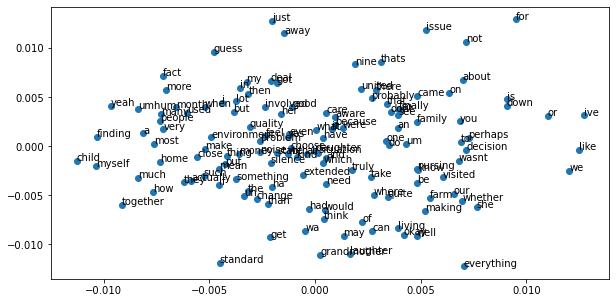

In [106]:
#retrive the vectors from the model 
vectors = word2vec[word2vec.wv.vocab]
#instantiate the PCA class with 2 dimensions
pca = PCA(n_components=2)
#train the model 
result = pca.fit_transform(vectors)
#plot a scatter plot
plt.rcParams['figure.figsize'] = [10, 10]

plt.scatter(x=result[:, 0], y=result[:, 1])
#add annotations of the words to the data points
words = list(word2vec.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, size=10, xy=(result[i, 0], result[i, 1]))